<a href="https://colab.research.google.com/github/harshitajain523/TransCMFD_Copy_Move_Forgery_Detection/blob/main/Initial_working_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")


#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device name: NVIDIA A100-SXM4-40GB
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# Helper Modules
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.gn = nn.GroupNorm(32, out_channels) # GroupNorm works well when batch size is small or varies
        self.relu = nn.ReLU(inplace=True)
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.gn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x

class Bridge(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)

# ----------------------------------------------------------------------------- #
# UpBlock
class UpBlockForUNetWithResNet50(nn.Module):
    def __init__(self, in_channels_after_concat, out_channels, up_conv_in_channels, up_conv_out_channels,
                 upsampling_method="bilinear"):
        super().__init__()

        self.upsampling_method = upsampling_method
        if upsampling_method == "conv_transpose":
            self.upsample_layer = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample_layer = nn.Upsample(scale_factor=2.0, mode='bilinear', align_corners=False)
        else:
            raise ValueError("Unsupported upsampling_method")

        self.conv_block = ConvBlock(in_channels_after_concat, out_channels)

    def forward(self, up_x, down_x):
        up_x = self.upsample_layer(up_x)

        # Handle potential size mismatch after upsampling (due to odd dimensions etc.)
        if up_x.shape[2] != down_x.shape[2] or up_x.shape[3] != down_x.shape[3]:
            up_x = F.interpolate(up_x, size=(down_x.shape[2], down_x.shape[3]), mode='bilinear', align_corners=False)

        x = torch.cat([up_x, down_x], 1)
        x = self.conv_block(x)
        return x

# ----------------------------------------------------------------------------- #

# CNN Encoder
class Encoder(nn.Module):
    # CNN Encoder based on a pre-trained ResNet-50.
    # Modified to use 3 convolution stages, making layer3's output (1024 channels) the deepest.
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)

        # ResNet-50 structure:
        # 0: Conv2d (initial 7x7)
        # 1: BatchNorm2d
        # 2: ReLU
        # 3: MaxPool2d
        # 4: layer1 (residual block, 64 channels out) - spatial size 56x56 for 224x224 input
        # 5: layer2 (residual block, 128 channels out) - spatial size 28x28
        # 6: layer3 (residual block, 256 channels out) - spatial size 14x14
        # 7: layer4 (residual block, 512 channels out) - spatial size 7x7
        # 8: AvgPool2d
        # 9: Linear (FC layer)

        # Input block: initial conv, BN, ReLU, MaxPool
        self.input_block = nn.Sequential(*list(resnet.children()))[:4] # Still corresponds to 64 channels output

        # Down blocks: layer1, layer2, layer3
        # We want to stop before layer4 to get 1024 channels (output of layer3)
        down_blocks = []
        # We need `list(resnet.children())[4:7]` to get layer1, layer2, layer3
        # ResNet's `layer1` outputs 256 channels
        # ResNet's `layer2` outputs 512 channels
        # ResNet's `layer3` outputs 1024 channels
        # ResNet's `layer4` outputs 2048 channels

        # Original code comment suggests channels:
        # layer1: 256, layer2: 512, layer3: 1024, layer4: 2048
        # The structure is: input_block -> 64 channel feature.
        # then layer1 (block 4) outputs 256.
        # layer2 (block 5) outputs 512.
        # layer3 (block 6) outputs 1024.
        # layer4 (block 7) outputs 2048.

        # We will use blocks 4, 5, 6 (layer1, layer2, layer3)
        self.down_blocks = nn.ModuleList(list(resnet.children())[4:7]) # This will include layer1, layer2, layer3

    def forward(self, x):
        pre_pools = dict()
        pre_pools["layer_0"] = x # Original input image for the very last decoder stage (512x512 initially)

        x = self.input_block(x) # Output e.g., (B, 64, 56, 56) for 224x224 input
        pre_pools["layer_1"] = x # Skip connection for decoder's up_block4

        # After input_block, the spatial dims for 224x224 input:
        # Initial 224x224 -> MaxPool (stride 2) -> 112x112 -> MaxPool (stride 2) -> 56x56
        # The first layer of ResNet (layer1) starts operating on 56x56

        # down_blocks contains: layer1, layer2, layer3
        # pre_pools["layer_1"] is the output of input_block (64 channels, spatial 56x56)
        # pre_pools["layer_2"] will be output of layer1 (256 channels, spatial 56x56)
        # pre_pools["layer_3"] will be output of layer2 (512 channels, spatial 28x28)
        # pre_pools["layer_4"] will be output of layer3 (1024 channels, spatial 14x14) - this is the deepest feature

        # The loop now runs for 3 blocks (layer1, layer2, layer3)
        for i, block in enumerate(self.down_blocks):
            x = block(x)
            # Store skip connections. layer_i+2 maps to pre_pools:
            # i=0 (layer1): x is output of layer1. Store as pre_pools["layer_2"]
            # i=1 (layer2): x is output of layer2. Store as pre_pools["layer_3"]
            # i=2 (layer3): x is output of layer3. This is the deepest feature; it goes to bridge/transformer.
            # We don't store it as a 'pre_pool' because it's directly passed to the bridge.
            if i < len(self.down_blocks) - 1: # ALL but the last one (layer3 output is going to bridge)
                pre_pools[f"layer_{i+2}"] = x

        # `x` here is the output of layer3 (1024 channels, 14x14 spatial for 224x224 input)
        return x, pre_pools

# ----------------------------------------------------------------------------- #
class Decoder(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        # Decoder stages:
        # For 224x224 input, spatial resolutions are:
        # Encoder: Input -> 56x56 (input_block/layer1) -> 28x28 (layer2) -> 14x14 (layer3/bridge)
        # Decoder stages will upsample: 14x14 -> 28x28 -> 56x56 -> 112x112 -> 224x224

        # Up-block 1: Fuses deepest feature (from bridge/transformer output) with ResNet.layer2 output
        # up_x (from bridge) is 1024 channels, 14x14. Skip (pre_pools["layer_3"]) is 512 channels, 28x28.
        # Up-x after upsample becomes 1024 channels, 28x28.
        # Concatenated: 1024 + 512 = 1536 channels. Output: 512 channels, 28x28 spatial.
        self.up_block1 = UpBlockForUNetWithResNet50(
            in_channels_after_concat=1024 + 512, out_channels=512,
            up_conv_in_channels=1024, up_conv_out_channels=1024
        )
        # Up-block 2: Fuses output of up_block1 with ResNet.layer1 output
        # up_x (from up_block1) is 512 channels, 28x28. Skip (pre_pools["layer_2"]) is 256 channels, 56x56.
        # Up-x after upsample becomes 512 channels, 56x56.
        # Concatenated: 512 + 256 = 768 channels. Output: 256 channels, 56x56 spatial.
        self.up_block2 = UpBlockForUNetWithResNet50(
            in_channels_after_concat=512 + 256, out_channels=256,
            up_conv_in_channels=512, up_conv_out_channels=512
        )
        # Up-block 3: Fuses output of up_block2 with Encoder's input_block output
        # up_x (from up_block2) is 256 channels, 56x56. Skip (pre_pools["layer_1"]) is 64 channels, 56x56.
        # Concatenated: 256 + 64 = 320 channels. Output: 128 channels, 56x56 spatial.
        self.up_block3 = UpBlockForUNetWithResNet50(
            in_channels_after_concat=256 + 64, out_channels=128,
            up_conv_in_channels=256, up_conv_out_channels=256
        )

        # Up-block 4: Fuses output of up_block3 with original input (pre_pools["layer_0"])
        # up_x (from up_block3) is 128 channels, 56x56.
        # up-x after upsample becomes 128 channels, 112x112
        # Original input (pre_pools["layer_0"]) is 3 channels, 224x224.
        # There's a mismatch here; the upsampling from 56x56 to 112x112 is one step,
        # but the target is 224x224. We need an additional upsampling step or modify `up_block4` logic.

        # Let's adjust the final stages.
        # The output of up_block3 is 128 channels, 56x56.
        # We need to upsample this to 224x224 (2 steps: 56->112, 112->224)

        # First upsample from 56x56 to 112x112
        self.upsample_to_112 = nn.Upsample(scale_factor=2.0, mode='bilinear', align_corners=False)
        self.conv_after_upsample_112 = ConvBlock(128, 64) # Reduce channels after upsampling

        # Second upsample from 112x112 to 224x224 and final convolution
        self.upsample_to_224 = nn.Upsample(scale_factor=2.0, mode='bilinear', align_corners=False)
        # Concatenate with pre_pools["layer_0"] (the original input image)
        # After self.conv_after_upsample_112, we have 64 channels.
        # Original input (pre_pools["layer_0"]) has 3 channels.
        # So, in_channels_after_concat will be 64 + 3 = 67.
        self.final_conv_block = ConvBlock(in_channels=64 + 3, out_channels=64)

        # Output layer
        self.out = nn.Conv2d(64, n_classes, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x, pre_pools):
        # x is the deepest feature (from bridge/transformer path), 14x14 spatial
        x = self.up_block1(x, pre_pools["layer_3"]) # Output: 512 channels, 28x28 spatial
        x = self.up_block2(x, pre_pools["layer_2"]) # Output: 256 channels, 56x56 spatial
        x = self.up_block3(x, pre_pools["layer_1"]) # Output: 128 channels, 56x56 spatial

        # Now, upsample from 56x56 to 224x224 (target original input size)
        # Step 1: 56x56 -> 112x112
        x = self.upsample_to_112(x) # 128 channels, 112x112
        x = self.conv_after_upsample_112(x) # 64 channels, 112x112

        # Step 2: 112x112 -> 224x224, then concatenate with original input (pre_pools["layer_0"])
        x = self.upsample_to_224(x) # 64 channels, 224x224

        # Concatenate with original input image (pre_pools["layer_0"])
        # Ensure sizes match, although interpolate in up_block handles this.
        # But here, we explicitly concatenate the final upsampled feature with the original input.
        # Original input `pre_pools["layer_0"]` is (B, 3, 224, 224)
        x = torch.cat([x, pre_pools["layer_0"]], 1) # (B, 64+3, 224, 224)

        x = self.final_conv_block(x) # (B, 64, 224, 224)

        x = self.out(x) # (B, n_classes, 224, 224)
        return x

# CRITICAL FIX: Enhanced Numerical Stability for FSM with explicit float32 casting
class FeatureSimilarityModule(nn.Module):
    def __init__(self):
        super(FeatureSimilarityModule, self).__init__()
        self.K = 32 # Number of top similarities to select [cite: 343]

    def forward(self, feature_map):
        batch_size, channels, H, W = feature_map.shape
        block_size_spatial = 16
        num_blocks_h = H // block_size_spatial
        num_blocks_w = W // block_size_spatial
        num_blocks = num_blocks_h * num_blocks_w

        blocks_unfolded = feature_map.unfold(2, block_size_spatial, block_size_spatial).unfold(3, block_size_spatial, block_size_spatial)
        blocks_flat = blocks_unfolded.permute(0, 2, 3, 1, 4, 5).contiguous().view(batch_size, num_blocks, -1)

        original_dtype = blocks_flat.dtype

        blocks_flat_f32 = blocks_flat.float() # Cast to float32, this is base for FSM calcs

        mean = torch.mean(blocks_flat_f32, dim=2, keepdim=True)
        centered_blocks = blocks_flat_f32 - mean

        epsilon_val = 1e-3 # Keep this for general stability

        std = torch.std(blocks_flat_f32, dim=2, keepdim=True, unbiased=False)
        std_safe = std + epsilon_val

        # DEBUG: Print std and std_safe (uncomment for debugging)
        #print(f"DEBUG FSM: std min: {std.min().item():.6f}, max: {std.max().item():.6f}")
        #print(f"DEBUG FSM: std_safe min: {std_safe.min().item():.6f}, max: {std_safe.max().item():.6f}")


        normalized_blocks = centered_blocks / std_safe

        # DEBUG: Print normalized_blocks (uncomment for debugging)
        #print(f"DEBUG FSM: normalized_blocks min: {normalized_blocks.min().item():.6f}, max: {normalized_blocks.max().item():.6f}")
        #print(f"DEBUG FSM: normalized_blocks NaN: {torch.isnan(normalized_blocks).any()}, Inf: {torch.isinf(normalized_blocks).any()}")


        clip_val = 1000.0 #
        normalized_blocks = torch.clamp(normalized_blocks, -clip_val, clip_val)

        # DEBUG: Print normalized_blocks after clamping (uncomment for debugging)
        #print(f"DEBUG FSM: normalized_blocks (clamped) min: {normalized_blocks.min().item():.6f}, max: {normalized_blocks.max().item():.6f}")

                  # CRITICAL FIX: Explicitly ensure matmul operands are float32 right before the operation.
        # This is the most robust way to hint autocast to perform this in float32,
        # or at least prevent intermediate float16 overflows.
        A_matmul = normalized_blocks.float() # Ensure float32. Though already float(), reinforces it.
        B_matmul = normalized_blocks.transpose(1, 2).float().contiguous() # Ensure float32 and contiguous
        # Temporarily disable autocast for the matmul operation
        original_autocast_state = torch.is_autocast_enabled()
        torch.set_autocast_enabled(False) # Disable autocast globally
        try:
          similarity_matrix = torch.matmul(A_matmul, B_matmul)
        finally:
          torch.set_autocast_enabled(original_autocast_state) # Re-enable it


        # DEBUG: Print similarity_matrix after matmul (uncomment for debugging)
        #print(f"DEBUG FSM: similarity_matrix (after matmul) min: {similarity_matrix.min().item():.6f}, max: {similarity_matrix.max().item():.6f}")
        #print(f"DEBUG FSM: similarity_matrix (after matmul) NaN: {torch.isnan(similarity_matrix).any()}, Inf: {torch.isinf(similarity_matrix).any()}")

        D_block = blocks_flat_f32.shape[2]
        similarity_matrix = similarity_matrix / D_block

        # DEBUG: Print similarity_matrix after final division (uncomment for debugging)
        #print(f"DEBUG FSM: similarity_matrix (after final div) min: {similarity_matrix.min().item():.6f}, max: {similarity_matrix.max().item():.6f}")
        #print(f"DEBUG FSM: similarity_matrix (after final div) NaN: {torch.isnan(similarity_matrix).any()}, Inf: {torch.isinf(similarity_matrix).any()}")

        # CRITICAL: Add clamping before converting back to original_dtype (float16)
        if original_dtype == torch.float16:
            similarity_matrix = torch.clamp(similarity_matrix, min=-65500.0, max=65500.0) # Ensure values fit within FP16 range
            # DEBUG: Print clamped for FP16 (uncomment for debugging)
            # print(f"DEBUG FSM: similarity_matrix (clamped for FP16) min: {similarity_matrix.min().item():.6f}, max: {similarity_matrix.max().item():.6f}")

        similarity_matrix = similarity_matrix.to(original_dtype)

        # DEBUG: Print similarity_matrix after final conversion (uncomment for debugging)
        #print(f"DEBUG FSM: similarity_matrix (final) min: {similarity_matrix.min().item():.6f}, max: {similarity_matrix.max().item():.6f}")
        #print(f"DEBUG FSM: similarity_matrix (final) NaN: {torch.isnan(similarity_matrix).any()}, Inf: {torch.isinf(similarity_matrix).any()}")

        # Percentile Pooling Block: Select top K similarities
        percentile_scores = torch.zeros(batch_size, num_blocks, self.K,
                                        device=feature_map.device, dtype=similarity_matrix.dtype)

        for b in range(batch_size):
            top_k_scores, _ = torch.topk(similarity_matrix[b], k=self.K, dim=-1, largest=True, sorted=True)
            percentile_scores[b] = top_k_scores

        return percentile_scores
# ==============================================================================


# Adaptive Transformer Components
# Custom Adaptive Multi-Head Self-Attention for the transformer's core innovation
class AdaptiveMultiHeadSelfAttention(nn.Module):
    """
    Custom Adaptive Multi-Head Self-Attention (AdaptiveMSA) module.
    Implements the Dual-Path Adaptive Attention Mechanism (DPAAM).
    """
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        if self.head_dim * num_heads != self.embed_dim:
            raise ValueError(f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})")

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        self.S1 = nn.Parameter(torch.zeros(embed_dim))
        self.S2 = nn.Parameter(torch.zeros(embed_dim))

        self.b1 = nn.Parameter(torch.zeros(embed_dim))
        self.b2 = nn.Parameter(torch.zeros(embed_dim))

        self.epsilon = nn.Parameter(torch.tensor(0.5))
        self.delta = nn.Parameter(torch.tensor(0.5))
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value):
        batch_size, seq_len, embed_dim = query.size()

        Q = self.q_proj(query)
        K = self.k_proj(key)
        V = self.v_proj(value)

        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        attention_weights = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attention_probs = F.softmax(attention_weights, dim=-1)

        Head_prime = torch.matmul(attention_probs, V)
        Head_prime_combined = Head_prime.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)

        M1_Head = self.S1 * Head_prime_combined + self.b1
        M2_Head = self.S2 * Head_prime_combined + self.b2

        epsilon_val = torch.sigmoid(self.epsilon)
        delta_val = torch.sigmoid(self.delta)

        adaptive_heads_combined = epsilon_val * M1_Head + delta_val * M2_Head

        output = self.out_proj(adaptive_heads_combined)
        return output


# Adaptive Transformer Components
class AdaptiveMultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        if self.head_dim * num_heads != self.embed_dim:
            raise ValueError(f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})")

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        self.S1 = nn.Parameter(torch.zeros(embed_dim)) # [cite: 44]
        self.S2 = nn.Parameter(torch.zeros(embed_dim)) # [cite: 44]
        self.b1 = nn.Parameter(torch.zeros(embed_dim)) # [cite: 44]
        self.b2 = nn.Parameter(torch.zeros(embed_dim)) # [cite: 44]

        # These parameters are now used for adaptive weighting
        self.epsilon = nn.Parameter(torch.tensor(0.5))
        self.delta = nn.Parameter(torch.tensor(0.5))

        self.out_proj = nn.Linear(embed_dim, embed_dim) # [cite: 45]

    def forward(self, query, key, value):
        batch_size, seq_len, embed_dim = query.size()

        Q = self.q_proj(query)
        K = self.k_proj(key)
        V = self.v_proj(value)

        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        attention_weights = torch.matmul(Q, K.transpose(-2,-1)) / (self.head_dim ** 0.5)
        attention_probs = F.softmax(attention_weights, dim=-1)

        Head_prime = torch.matmul(attention_probs, V)
        Head_prime_combined = Head_prime.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)

        M1_Head = self.S1 * Head_prime_combined + self.b1 # [cite: 343]
        M2_Head = self.S2 * Head_prime_combined + self.b2 # [cite: 344]

        epsilon_val = torch.sigmoid(self.epsilon) # [cite: 46]
        delta_val = torch.sigmoid(self.delta) # [cite: 46]

        adaptive_heads_combined = epsilon_val * M1_Head + delta_val * M2_Head # [cite: 46]

        output = self.out_proj(adaptive_heads_combined) # [cite: 46]
        return output

class AdaptiveTransformerLayer(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.adaptive_mhsa = AdaptiveMultiHeadSelfAttention(embed_dim=dim, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(dim) # [cite: 48]
        self.norm2 = nn.LayerNorm(dim) # [cite: 48]
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        attn_output = self.adaptive_mhsa(x, x, x)
        x = self.norm1(x + attn_output)
        x_mlp = self.mlp(x)
        x = self.norm2(x + x_mlp)
        return x

class AdaptiveTransformerEncoder(nn.Module):
    def __init__(self, dim, num_heads, num_layers, input_spatial_size):
        super().__init__()
        self.dim = dim
        self.num_layers = num_layers
        self.input_spatial_size = input_spatial_size
        self.layers = nn.ModuleList([AdaptiveTransformerLayer(dim, num_heads) for _ in range(num_layers)]) # [cite: 51]
        self.proj_to_dim = nn.Conv2d(1024, dim, kernel_size=1) # [cite: 52]
        self.pos_embedding = nn.Parameter(torch.randn(1, input_spatial_size * input_spatial_size, dim)) # [cite: 52]

    def forward(self, feature_map_c_deepest):
        x = self.proj_to_dim(feature_map_c_deepest)
        x = x.flatten(2).permute(0, 2, 1)
        if x.shape[1] != self.pos_embedding.shape[1]:
            raise ValueError(f"Positional embedding sequence length mismatch. Expected {self.pos_embedding.shape[1]}, got {x.shape[1]}")
        x = x + self.pos_embedding
        for layer in self.layers:
            x = layer(x)
        return x

class TransCMFDBaseline(nn.Module):
    def __init__(self, n_classes=1): # [cite: 54]
        super().__init__()
        self.encoder = Encoder() # [cite: 54]
        self.bridge = Bridge(1024, 1024) # [cite: 54]

        transformer_dim = 512
        transformer_heads = 8
        transformer_layers = 4
        transformer_input_spatial_size = 14

        self.adaptive_transformer_encoder = AdaptiveTransformerEncoder(
            dim=transformer_dim,
            num_heads=transformer_heads,
            num_layers=transformer_layers,
            input_spatial_size=transformer_input_spatial_size
        )
        self.transformer_output_to_fsm_input = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=False) # [cite: 55]
        self.fsm = FeatureSimilarityModule() # [cite: 56]
        self.fsm_output_fusion_transform = nn.Conv2d(self.fsm.K, 1024, kernel_size=1) # [cite: 58]
        self.decoder = Decoder(n_classes=n_classes) # [cite: 59]

    def forward(self, x):
        encoder_output_c_deepest, pre_pools = self.encoder(x) # [cite: 60]
        # DEBUG prints for Encoder Output
        #print(f"DEBUG: Encoder Output: Min={encoder_output_c_deepest.min().item():.4f}, Max={encoder_output_c_deepest.max().item():.4f}, Mean={encoder_output_c_deepest.mean().item():.4f}, NaN={torch.isnan(encoder_output_c_deepest).any()}, Inf={torch.isinf(encoder_output_c_deepest).any()}")
        #if torch.isnan(encoder_output_c_deepest).any() or torch.isinf(encoder_output_c_deepest).any():
            #raise ValueError("Encoder output is NaN/Inf!")

        x_bridge = self.bridge(encoder_output_c_deepest) # [cite: 61]
        # DEBUG prints for Bridge Output
        #print(f"DEBUG: Bridge Output: Min={x_bridge.min().item():.4f}, Max={x_bridge.max().item():.4f}, Mean={x_bridge.mean().item():.4f}, NaN={torch.isnan(x_bridge).any()}, Inf={torch.isinf(x_bridge).any()}")
        #if torch.isnan(x_bridge).any() or torch.isinf(x_bridge).any():
            #raise ValueError("Bridge output is NaN/Inf!")

        transformer_output_tokens = self.adaptive_transformer_encoder(encoder_output_c_deepest) # [cite: 61]
        # DEBUG prints for Transformer Output
        #print(f"DEBUG: Transformer Output: Min={transformer_output_tokens.min().item():.4f}, Max={transformer_output_tokens.max().item():.4f}, Mean={transformer_output_tokens.mean().item():.4f}, NaN={torch.isnan(transformer_output_tokens).any()}, Inf={torch.isinf(transformer_output_tokens).any()}")
        #if torch.isnan(transformer_output_tokens).any() or torch.isinf(transformer_output_tokens).any():
            #raise ValueError("Transformer output is NaN/Inf!")

        fsm_input_spatial_reshaped = transformer_output_tokens.permute(0, 2, 1).contiguous().view(
            transformer_output_tokens.size(0),
            self.adaptive_transformer_encoder.dim,
            self.adaptive_transformer_encoder.input_spatial_size,
            self.adaptive_transformer_encoder.input_spatial_size
        )
        fsm_input = self.transformer_output_to_fsm_input(fsm_input_spatial_reshaped) # [cite: 62]
        #DEBUG prints for FSM Input
        #print(f"DEBUG: FSM Input (upsampled): Min={fsm_input.min().item():.4f}, Max={fsm_input.max().item():.4f}, Mean={fsm_input.mean().item():.4f}, NaN={torch.isnan(fsm_input).any()}, Inf={torch.isinf(fsm_input).any()}")
        #if torch.isnan(fsm_input).any() or torch.isinf(fsm_input).any():
           #raise ValueError("FSM input is NaN/Inf!")

        fsm_output_raw = self.fsm(fsm_input) # [cite: 63]
        # DEBUG prints for FSM Output (this is the one that was failing)
        #print(f"DEBUG: FSM Output: Min={fsm_output_raw.min().item():.4f}, Max={fsm_output_raw.max().item():.4f}, Mean={fsm_output_raw.mean().item():.4f}, NaN={torch.isnan(fsm_output_raw).any()}, Inf={torch.isinf(fsm_output_raw).any()}")
        #if torch.isnan(fsm_output_raw).any() or torch.isinf(fsm_output_raw).any():
            #raise ValueError("FSM output is NaN/Inf!")

        fsm_output_spatial_for_fusion = fsm_output_raw.permute(0, 2, 1).contiguous().view(
            fsm_output_raw.size(0), self.fsm.K, 16, 16
        )
        fsm_output_fused = self.fsm_output_fusion_transform(fsm_output_spatial_for_fusion) # [cite: 65]
        fsm_output_fused_interpolated = F.interpolate(
            fsm_output_fused,
            size=(x_bridge.shape[2], x_bridge.shape[3]),
            mode='bilinear',
            align_corners=False
        )
        fused_decoder_input = x_bridge + fsm_output_fused_interpolated # [cite: 66]
        #DEBUG prints for Fused Decoder Input
        #print(f"DEBUG: Fused Decoder Input: Min={fused_decoder_input.min().item():.4f}, Max={fused_decoder_input.max().item():.4f}, Mean={fused_decoder_input.mean().item():.4f}, NaN={torch.isnan(fused_decoder_input).any()}, Inf={torch.isinf(fused_decoder_input).any()}")
        #if torch.isnan(fused_decoder_input).any() or torch.isinf(fused_decoder_input).any():
         #raise ValueError("Fused decoder input is NaN/Inf!")

        output = self.decoder(fused_decoder_input, pre_pools) # [cite: 66]
        # DEBUG prints for Decoder Output
        #print(f"DEBUG: Decoder Output (Final Predictions): Min={output.min().item():.4f}, Max={output.max().item():.4f}, Mean={output.mean().item():.4f}, NaN={torch.isnan(output).any()}, Inf={torch.isinf(output).any()}")
        #if torch.isnan(output).any() or torch.isinf(output).any():
            #raise ValueError("Final decoder output is NaN/Inf!")
        return output


# Dummy Data Testing
if __name__ == '__main__':
    print("Initializing TransCMFDBaseline model...")
    # It's good practice to set a device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransCMFDBaseline().to(device) # Instantiate model and move to device
    print(f"TransCMFDBaseline model successfully loaded on {device}.")

    print("\n--- Model Architecture Summary ---")
    print(model)
    print("----------------------------------\n")
    dummy_transform = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Dummy input: Batch size 2, 3 channels (RGB), 224x224 resolution
    dummy_input_raw = torch.rand((2, 3, 224, 224)) # Generate raw tensor (values 0-1)
    dummy_input = dummy_transform(dummy_input_raw).to(device) # <--- Apply normalization and move to device

    print(f"Dummy input shape: {dummy_input.shape}")

    with torch.no_grad(): # Disable gradient computation for faster dummy pass
        output = model(dummy_input)

    print(f"Output shape: {output.shape}")


Initializing TransCMFDBaseline model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TransCMFDBaseline model successfully loaded on cuda.

--- Model Architecture Summary ---
TransCMFDBaseline(
  (encoder): Encoder(
    (input_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [3]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms # Ensure this is imported

class CMFDataset(Dataset):
    """
    PyTorch Dataset for Copy-Move Forgery Detection using CASIA v2.0.
    Loads (Tampered Image, Ground Truth Mask) pairs and applies transformations.
    """
    def __init__(self, data_root, image_transform=None, mask_transform=None):
        self.data_root = data_root

        self.tampered_folder = os.path.join(data_root, 'Tp')
        self.gt_folder = os.path.join(data_root, 'CASIA 2 Groundtruth')

        self.image_transform = image_transform # <--- ADDED/MODIFIED
        self.mask_transform = mask_transform   # <--- ADDED


        self.data_pairs = []

        tampered_image_files = sorted([f for f in os.listdir(self.tampered_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])

        for img_name in tampered_image_files:
            img_path = os.path.join(self.tampered_folder, img_name)
            base_name_without_ext = os.path.splitext(img_name)[0]
            mask_name = f"{base_name_without_ext}_gt.png"
            mask_path = os.path.join(self.gt_folder, mask_name)

            if os.path.exists(mask_path):
                self.data_pairs.append((img_path, mask_path))
            else:
                print(f"Warning: Mask not found for {img_name} at {mask_path}. Skipping.")

        print(f"Loaded {len(self.data_pairs)} valid tampered image-mask pairs from {data_root}")

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.data_pairs[idx]

        # Load images using PIL
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # Assuming masks are grayscale


        # NEW: Apply the full transformation pipelines
        if self.image_transform:
            image_tensor = self.image_transform(image)
        else:
            image_tensor = transforms.ToTensor()(image)

        if self.mask_transform:
            mask_tensor = self.mask_transform(mask)
        else:
            mask_tensor = transforms.ToTensor()(mask)
            mask_tensor = (mask_tensor > 0.5).float()

        return image_tensor, mask_tensor

# ==============================================================================

In [4]:
import torchvision.transforms as transforms # Ensure this import is at the top of your file
from torch.utils.data import DataLoader # Ensure this import is at the top of your file
# Assuming CMFDataset class is defined and accessible here

# CHANGE 2.1: Define comprehensive transformation pipelines for images and masks.
# OLD: transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# NEW:
# Define the image transformations (ImageNet normalization is standard for ResNet pretrained)
IMAGE_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)), # <--- Resize the PIL Image to 224x224
    transforms.ToTensor(),         # <--- Convert to Tensor (scales [0, 255] to [0.0, 1.0])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # <--- Apply ImageNet Normalize
])

# Define the mask transformations
MASK_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST), # <--- Resize masks (use NEAREST for labels)
    transforms.ToTensor(), # <--- Convert to Tensor (scales [0, 255] to [0.0, 1.0])
    lambda x: (x > 0.5).float() # <--- Ensure mask is strictly binary (0.0 or 1.0)
])


CASIA_V2_ROOT = '/content/drive/MyDrive/TransCMFD_dataset/CASIA2'

full_dataset = CMFDataset(
    data_root=CASIA_V2_ROOT,
    image_transform=IMAGE_TRANSFORM, # <--- Pass the new image transform
    mask_transform=MASK_TRANSFORM    # <--- Pass the new mask transform
)


# Split dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

print(f"Dataset split: Training {len(train_dataset)} samples, Validation {len(val_dataset)} samples")

# Create DataLoaders
BATCH_SIZE = 1 # Keep at 1 for now due to memory, but the code allows changing to higher with accumulation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # num_workers > 0 for faster loading
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train DataLoader batches: {len(train_loader)}")
print(f"Validation DataLoader batches: {len(val_loader)}")

# --- Test Data Loading ---
print("\nTesting data loading...")
try:
    # Fetch one batch to verify shapes and types
    images, masks = next(iter(train_loader)) # Use next(iter()) to get one batch
    # CHANGE 2.3: Update expected print shapes for images and masks to 224x224
    print(f"Batch images shape: {images.shape}") # Should be (BATCH_SIZE, 3, 224, 224) <--- UPDATED EXPECTATION
    print(f"Batch images dtype: {images.dtype}") # Should be torch.float32
    print(f"Batch masks shape: {masks.shape}")   # Should be (BATCH_SIZE, 1, 224, 224) <--- UPDATED EXPECTATION
    print(f"Batch masks dtype: {masks.dtype}")   # Should be torch.float32
    print("Data loading successful!")
except Exception as e:
    print(f"Error during data loading test: {e}")
    print("Please double-check your CASIA_V2_ROOT path, folder structure (Tp, CASIA 2 Groundtruth), and mask naming.")
    print("Common issues: wrong root path, incorrect subfolder names, mask files not found for image files.")

Loaded 2004 valid tampered image-mask pairs from /content/drive/MyDrive/TransCMFD_dataset/CASIA2
Dataset split: Training 1603 samples, Validation 401 samples
Train DataLoader batches: 1603
Validation DataLoader batches: 401

Testing data loading...
Batch images shape: torch.Size([1, 3, 224, 224])
Batch images dtype: torch.float32
Batch masks shape: torch.Size([1, 1, 224, 224])
Batch masks dtype: torch.float32
Data loading successful!


In [6]:
import torch.optim as optim
from tqdm.notebook import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assuming your model definition (ConvBlock, Bridge, UpBlockForUNetWithResNet50,
# Encoder, Decoder, FeatureSimilarityModule, AdaptiveMultiHeadSelfAttention,
# AdaptiveTransformerLayer, AdaptiveTransformerEncoder, TransCMFDBaseline)
# is in the same file or imported correctly.

# If running as a script, ensure TransCMFDBaseline is defined or imported
# from your model file. For this example, I'll assume it's defined.

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    def forward(self, prediction, target):
        target = target.float()
        prediction = torch.sigmoid(prediction) #sigmoid for conversion to probabilities
        prediction_flat = prediction.contiguous().view(-1)
        target_flat = target.contiguous().view(-1)
        intersection = (prediction_flat * target_flat).sum()
        dice_coefficient = (2. * intersection + self.smooth) / (prediction_flat.sum() + target_flat.sum() + self.smooth)
        return 1 - dice_coefficient
# CORRECTED AdaptiveRegularizationLoss
class AdaptiveRegularizationLoss(nn.Module):
    def __init__(self):
        super(AdaptiveRegularizationLoss, self).__init__() # [cite: 171]

    def forward(self, model):
        l_adapt_total = 0.0
        if hasattr(model, 'adaptive_transformer_encoder') and \
           hasattr(model.adaptive_transformer_encoder, 'layers'):
            for layer in model.adaptive_transformer_encoder.layers:
                if hasattr(layer, 'adaptive_mhsa'):
                    s1_param = layer.adaptive_mhsa.S1
                    s2_param = layer.adaptive_mhsa.S2
                    # CORRECTED: Changed to positive sum of squared L2 norms for regularization
                    l_adapt_total += torch.norm(s1_param, 2)**2
                    l_adapt_total += torch.norm(s2_param, 2)**2
        return l_adapt_total

dice_loss_fn = DiceLoss(smooth=1.0)
bce_loss_fn = nn.BCEWithLogitsLoss()
adaptive_reg_loss_fn = AdaptiveRegularizationLoss()

LEARNING_RATE = 1e-5 #
ALPHA = 0.5 #
BETA = 0.5 #
GAMMA = 0.001 # Changed from 0.00 to 0.001 to enable regularization
NUM_EPOCHS = 10
GRADIENT_ACCUMULATION_STEPS = 4 #

def train_model(model, train_loader, val_loader, optimizer, dice_loss,
                bce_loss, adaptive_reg_loss, num_epochs, alpha, beta, gamma,
                scheduler=None, gradient_accumulation_steps=1):

    model.train()
    device = next(model.parameters()).device
    scaler = torch.cuda.amp.GradScaler(enabled=True) # Use enabled=True for clarity, default is True if CUDA is available

    best_val_loss = float('inf')
    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        train_loop = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
        optimizer.zero_grad() # Zero gradients for accumulation at the start of epoch/accumulation cycle

        for batch_idx, (images, masks) in enumerate(train_loop):
            images = images.to(device, non_blocking=True) #
            masks = masks.to(device, non_blocking=True) #

            if torch.isnan(images).any() or torch.isinf(images).any():
                print(f"Warning: NaN or Inf found in images at batch {batch_idx}! Skipping batch.") # [cite: 175]
                optimizer.zero_grad() # Clear any partial gradients
                continue
            if torch.isnan(masks).any() or torch.isinf(masks).any():
                print(f"Warning: NaN or Inf found in masks at batch {batch_idx}! Skipping batch.") # [cite: 175]
                optimizer.zero_grad() # Clear any partial gradients
                continue

            with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True): # Use dtype=torch.float16 for clarity
                predictions = model(images)

                if (batch_idx % 10 == 0) or torch.isnan(predictions).any() or torch.isinf(predictions).any():
                    pred_min = predictions.min().item()
                    pred_max = predictions.max().item()
                    pred_mean = predictions.mean().item()
                   # print(f"\nBatch {batch_idx}: Pred Logits Min: {pred_min:.4f}, Max: {pred_max:.4f}, Mean: {pred_mean:.4f}") # [cite: 175]
                    if torch.isnan(predictions).any() or torch.isinf(predictions).any():
                        print(" !!! NaN or Inf detected in predictions BEFORE loss calculation !!!") # [cite: 175]
                        raise ValueError("NaN/Inf predictions detected. Stopping for debug.")

                l_dice = dice_loss(predictions, masks) # [cite: 176]
                l_bce = bce_loss(predictions, masks) # [cite: 176]
                l_adapt = adaptive_reg_loss(model) # [cite: 176]
                total_loss = alpha * l_dice + beta * l_bce + gamma * l_adapt # [cite: 176]
                total_loss = total_loss / gradient_accumulation_steps # [cite: 176]

            if (batch_idx % 10 == 0) or torch.isnan(total_loss): # [cite: 176]
                if torch.isnan(l_dice) or torch.isnan(l_bce) or torch.isnan(l_adapt):
                    print(f"\n !!! NaN in a loss component at batch {batch_idx}! ") # [cite: 177]
                    print(f" l_dice: {l_dice.item() if not torch.isnan(l_dice) else 'NaN'}") # [cite: 177]
                    print(f" l_bce: {l_bce.item() if not torch.isnan(l_bce) else 'NaN'}") # [cite: 177]
                    print(f" l_adapt: {l_adapt.item() if not torch.isnan(l_adapt) else 'NaN'}") # [cite: 177]
                if torch.isnan(total_loss): # [cite: 177]
                    raise ValueError(f"NaN total loss detected at batch {batch_idx}. Component issue suspected.")

            scaler.scale(total_loss).backward() # Accumulate scaled gradients [cite: 177]

            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                scaler.unscale_(optimizer) # Unscale the gradients before clipping, if clipping is used
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Example: Clip gradients
                scaler.step(optimizer) # Update model parameters
                scaler.update() # Update the scaler for next iteration
                optimizer.zero_grad() # Clear gradients for the next accumulation cycle

            # Adjust running loss to reflect the unscaled loss per sample
            running_loss += total_loss.item() * images.size(0) * gradient_accumulation_steps # Corrected for proper running loss
            train_loop.set_postfix(loss=total_loss.item() * gradient_accumulation_steps) # Display unscaled loss

        # Handle any remaining accumulated gradients from the last partial batch
        if (batch_idx + 1) % gradient_accumulation_steps != 0: #
            scaler.unscale_(optimizer) # Unscale before clipping if needed [cite: 179]
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Example: Clip gradients [cite: 180]
            scaler.step(optimizer) # [cite: 180]
            scaler.update() # [cite: 180]
            optimizer.zero_grad() # [cite: 180]

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1} Training Loss: {epoch_loss:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}")
            for images, masks in val_loop:
                images = images.to(device, non_blocking=True) # [cite: 180]
                masks = masks.to(device, non_blocking=True) # [cite: 180]

                with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
                    predictions = model(images)
                    l_dice_val = dice_loss(predictions, masks) # [cite: 180]
                    l_bce_val = bce_loss(predictions, masks) # [cite: 180]
                    l_adapt_val = adaptive_reg_loss(model) # [cite: 180]
                    total_val_loss = alpha * l_dice_val + beta * l_bce_val + gamma * l_adapt_val # [cite: 180]

                val_loss += total_val_loss.item() * images.size(0) # [cite: 180]
                val_loop.set_postfix(val_loss=total_val_loss.item())

            epoch_val_loss = val_loss / len(val_loader.dataset)
            print(f"Epoch {epoch+1} Validation Loss: {epoch_val_loss:.4f}") # [cite: 180]

            if scheduler:
                scheduler.step(epoch_val_loss) # For ReduceLROnPlateau [cite: 180]

            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                checkpoint_path = "/content/drive/MyDrive/TransCMFD_Checkpoints/best_model.pth" # [cite: 181]
                os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True) # [cite: 181]
                torch.save(model.state_dict(), checkpoint_path) # [cite: 182]
                print(f"Model saved to {checkpoint_path} with validation loss: {best_val_loss:.4f}") # [cite: 182]

    print("\nTraining complete!")

if __name__ == '__main__':
    # Assuming 'TransCMFDBaseline' class is available (from previous code block)
    # and 'full_dataset' and 'DataLoader' are imported/defined.
    # For a standalone run of this file, you'd need these:
    from torch.utils.data import DataLoader, Dataset
    import torchvision.transforms as transforms

    # Dummy Dataset for demonstration if full_dataset is not defined
    class DummyDataset(Dataset):
        def __init__(self, num_samples=100, img_size=224):
            self.num_samples = num_samples
            self.img_size = img_size

        def __len__(self):
            return self.num_samples

        def __getitem__(self, idx):
            image = torch.rand(3, self.img_size, self.img_size)
            mask = (torch.rand(1, self.img_size, self.img_size) > 0.5).float()
            return image, mask

    try:
        # Check if full_dataset exists from previous execution context
        _ = full_dataset
    except NameError:
        print("full_dataset not found. Creating a DummyDataset for demonstration.") # [cite: 183]
        full_dataset = DummyDataset(num_samples=1000, img_size=224) # Adjust num_samples

    # Instantiate model and move to device HERE
    model = TransCMFDBaseline().to(device) # [cite: 184]
    print(f"Model instantiated on: {device}") # [cite: 184]

    # Define Optimizer (needs to be after model instantiation)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # [cite: 185]

    # Learning Rate Scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True) # [cite: 185]

    BATCH_SIZE = 2 # [cite: 185]
    NUM_WORKERS = os.cpu_count() # [cite: 185]
    if NUM_WORKERS is None:
        NUM_WORKERS = 0 # Fallback for environments where os.cpu_count() might return None
    print(f"Using BATCH_SIZE: {BATCH_SIZE}, NUM_WORKERS: {NUM_WORKERS}") # [cite: 185]

    # DataLoaders setup
    train_size = int(0.8 * len(full_dataset)) # [cite: 185]
    val_size = len(full_dataset) - train_size # [cite: 186]
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size]) # [cite: 186]

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True) # [cite: 186]
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True) # [cite: 186]

    print("DataLoaders re-created with new batch size, num workers, and pin_memory=True.") # [cite: 187]

    print("\nStarting model training...") # [cite: 187]
    train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        dice_loss_fn,
        bce_loss_fn,
        adaptive_reg_loss_fn,
        NUM_EPOCHS,
        ALPHA,
        BETA,
        GAMMA,
        scheduler=scheduler, # Pass the scheduler
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS # Pass accumulation steps
    )

Model instantiated on: cuda
Using BATCH_SIZE: 2, NUM_WORKERS: 12
DataLoaders re-created with new batch size, num workers, and pin_memory=True.

Starting model training...

Epoch 1/10


/tmp/ipython-input-6-614129135.py:67: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True) # Use enabled=True for clarity, default is True if CUDA is available


Training Epoch 1:   0%|          | 0/802 [00:00<?, ?it/s]

Epoch 1 Training Loss: 0.6252


Validation Epoch 1:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1 Validation Loss: 0.5860
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model.pth with validation loss: 0.5860

Epoch 2/10


Training Epoch 2:   0%|          | 0/802 [00:00<?, ?it/s]

Epoch 2 Training Loss: 0.5607


Validation Epoch 2:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2 Validation Loss: 0.5565
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model.pth with validation loss: 0.5565

Epoch 3/10


Training Epoch 3:   0%|          | 0/802 [00:00<?, ?it/s]

Epoch 3 Training Loss: 0.5214


Validation Epoch 3:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3 Validation Loss: 0.5478
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model.pth with validation loss: 0.5478

Epoch 4/10


Training Epoch 4:   0%|          | 0/802 [00:00<?, ?it/s]

Epoch 4 Training Loss: 0.4886


Validation Epoch 4:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 4 Validation Loss: 0.5359
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model.pth with validation loss: 0.5359

Epoch 5/10


Training Epoch 5:   0%|          | 0/802 [00:00<?, ?it/s]

Epoch 5 Training Loss: 0.4549


Validation Epoch 5:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 5 Validation Loss: 0.5262
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model.pth with validation loss: 0.5262

Epoch 6/10


Training Epoch 6:   0%|          | 0/802 [00:00<?, ?it/s]

Epoch 6 Training Loss: 0.4278


Validation Epoch 6:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 6 Validation Loss: 0.5167
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model.pth with validation loss: 0.5167

Epoch 7/10


Training Epoch 7:   0%|          | 0/802 [00:00<?, ?it/s]

Epoch 7 Training Loss: 0.4017


Validation Epoch 7:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 7 Validation Loss: 0.5115
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model.pth with validation loss: 0.5115

Epoch 8/10


Training Epoch 8:   0%|          | 0/802 [00:00<?, ?it/s]

Epoch 8 Training Loss: 0.3826


Validation Epoch 8:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 8 Validation Loss: 0.4917
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model.pth with validation loss: 0.4917

Epoch 9/10


Training Epoch 9:   0%|          | 0/802 [00:00<?, ?it/s]

Epoch 9 Training Loss: 0.3642


Validation Epoch 9:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 9 Validation Loss: 0.4913
Model saved to /content/drive/MyDrive/TransCMFD_Checkpoints/best_model.pth with validation loss: 0.4913

Epoch 10/10


Training Epoch 10:   0%|          | 0/802 [00:00<?, ?it/s]

Epoch 10 Training Loss: 0.3485


Validation Epoch 10:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 10 Validation Loss: 0.4997

Training complete!


TESTING


In [7]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt # For plotting and visualization

# Important: Make sure all your model classes (ConvBlock, Bridge, etc.)
# are defined or imported here before TransCMFDBaseline.
# For simplicity, if they are in the same script, just include their definitions.

# If your model classes are in a separate file (e.g., 'model_arch.py'),
# you would import them like this:
# from your_model_file import ConvBlock, Bridge, UpBlockForUNetWithResNet50, Encoder, Decoder, FeatureSimilarityModule, AdaptiveMultiHeadSelfAttention, AdaptiveTransformerLayer, AdaptiveTransformerEncoder, TransCMFDBaseline

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [8]:
# Instantiate your TransCMFDBaseline model
# Make sure n_classes matches what you used during training (likely 1)
model = TransCMFDBaseline(n_classes=1).to(device)

# Define the path to your saved best model checkpoint
checkpoint_path = "/content/drive/MyDrive/TransCMFD_Checkpoints/best_model.pth"

# Load the saved state_dict into the model
try:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"Model weights loaded successfully from {checkpoint_path}")
except FileNotFoundError:
    print(f"Error: Checkpoint file not found at {checkpoint_path}. Please check the path.")
    # Exit or handle the error gracefully if the file isn't there.
    # For now, we'll just print and stop.
    exit() # Or some other error handling

# Set the model to evaluation mode
# This is crucial! It disables dropout, batch norm updates, etc.,
# which behave differently during inference.
model.eval()
print("Model is ready for evaluation.")

Model weights loaded successfully from /content/drive/MyDrive/TransCMFD_Checkpoints/best_model.pth
Model is ready for evaluation.


In [9]:
# Define the image transformations (same as IMAGE_TRANSFORM used in training)
# IMPORTANT: For visualization, we often want the *original* image pixels (0-255 or 0-1)
# without ImageNet normalization for displaying.
# So, for the model input, use IMAGE_TRANSFORM.
# For displaying the original image, just use ToTensor().

# Transform for model input (includes normalization)
MODEL_INPUT_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # Converts PIL Image to Tensor (scales to [0.0, 1.0])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet Normalize
])

# Transform for displaying original image (only ToTensor)
DISPLAY_IMAGE_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor() # Only convert to Tensor, no normalization
])

# Define the mask transformations (same as MASK_TRANSFORM used in training)
MASK_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(), # Converts PIL Image to Tensor (scales to [0.0, 1.0])
    lambda x: (x > 0.5).float() # Ensure mask is strictly binary (0.0 or 1.0)
])

# Define your dataset root (same as used in training)
CASIA_V2_ROOT = '/content/drive/MyDrive/TransCMFD_dataset/CASIA2'

# Instantiate the dataset. Use the MASK_TRANSFORM for GT masks.
# For images, we'll load them separately for model input and display.
val_dataset_raw = CMFDataset(
    data_root=CASIA_V2_ROOT,
    # For CMFDataset, we pass the transforms it expects.
    # We'll handle MODEL_INPUT_TRANSFORM and DISPLAY_IMAGE_TRANSFORM directly in the visualization loop.
    image_transform=transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()]), # Just resize and to tensor for CMFDataset's internal loading
    mask_transform=MASK_TRANSFORM
)

print(f"Loaded {len(val_dataset_raw)} samples for visualization access.")

Loaded 2004 valid tampered image-mask pairs from /content/drive/MyDrive/TransCMFD_dataset/CASIA2
Loaded 2004 samples for visualization access.


In [10]:
def visualize_single_prediction(model, image_path, mask_path, device, model_input_transform, display_image_transform):
    """
    Loads an original image and its GT mask, makes a prediction using the model,
    and visualizes the original, GT, and predicted mask.
    """
    # Load original image using PIL
    original_image_pil = Image.open(image_path).convert("RGB")

    # Load ground truth mask using PIL
    gt_mask_pil = Image.open(mask_path).convert("L")

    # --- Prepare image for model input ---
    input_tensor = model_input_transform(original_image_pil).unsqueeze(0).to(device) # Add batch dim, move to device

    # --- Make prediction ---
    with torch.no_grad(): # No need to calculate gradients for inference
        prediction_logits = model(input_tensor)
        prediction_probs = torch.sigmoid(prediction_logits)
        predicted_mask_tensor = (prediction_probs > 0.5).float().squeeze(0).cpu() # Remove batch dim, move to CPU

    # --- Prepare images for display ---
    # Original image for display (0-1 tensor, not normalized)
    original_image_display = display_image_transform(original_image_pil).permute(1, 2, 0).numpy() # Convert to HWC, numpy

    # Ground Truth mask for display (0-1 tensor, single channel)
    gt_mask_display = MASK_TRANSFORM(gt_mask_pil).squeeze().numpy() # Remove channel dim, numpy

    # Predicted mask for display (0-1 tensor, single channel)
    predicted_mask_display = predicted_mask_tensor.squeeze().numpy() # Remove channel dim, numpy

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 row, 3 columns

    # Plot Original Image
    axes[0].imshow(original_image_display)
    axes[0].set_title("Original Image")
    axes[0].axis('off') # Hide axes ticks

    # Plot Ground Truth Mask
    axes[1].imshow(gt_mask_display, cmap='gray') # Use 'gray' colormap for binary masks
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    # Plot Predicted Mask
    axes[2].imshow(predicted_mask_display, cmap='gray') # Use 'gray' colormap
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    plt.suptitle(f"Prediction for: {os.path.basename(image_path)}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()


--- Visualizing Predictions ---

Visualizing sample index 0: Tp_D_CND_S_N_txt00028_txt00006_10848.jpg


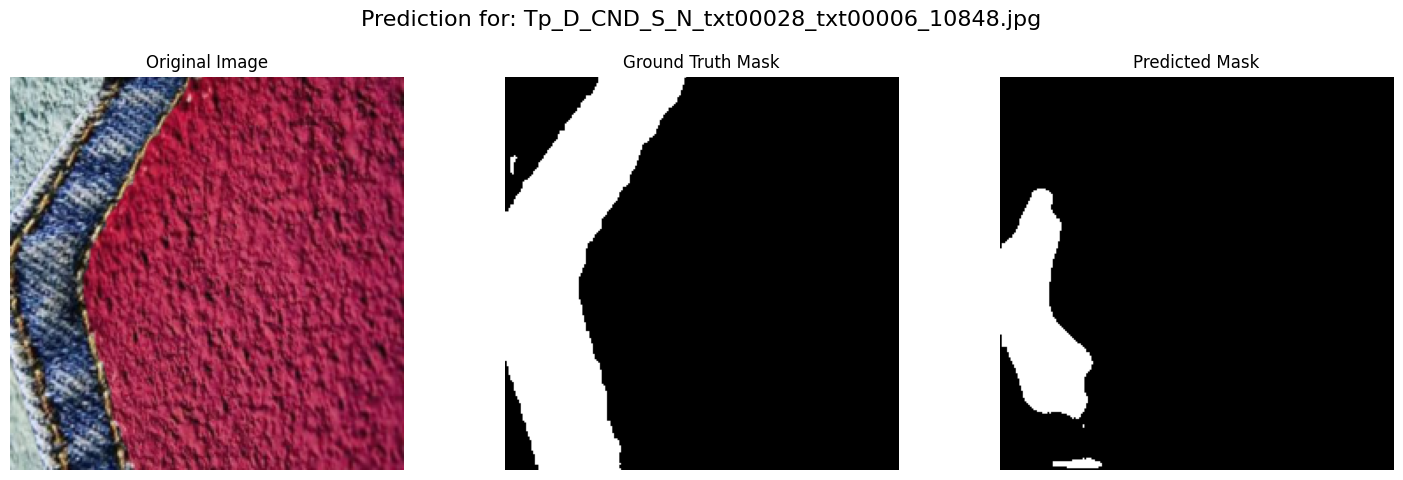


Visualizing sample index 100: Tp_D_CRN_M_N_pla00046_pla00025_10994.jpg


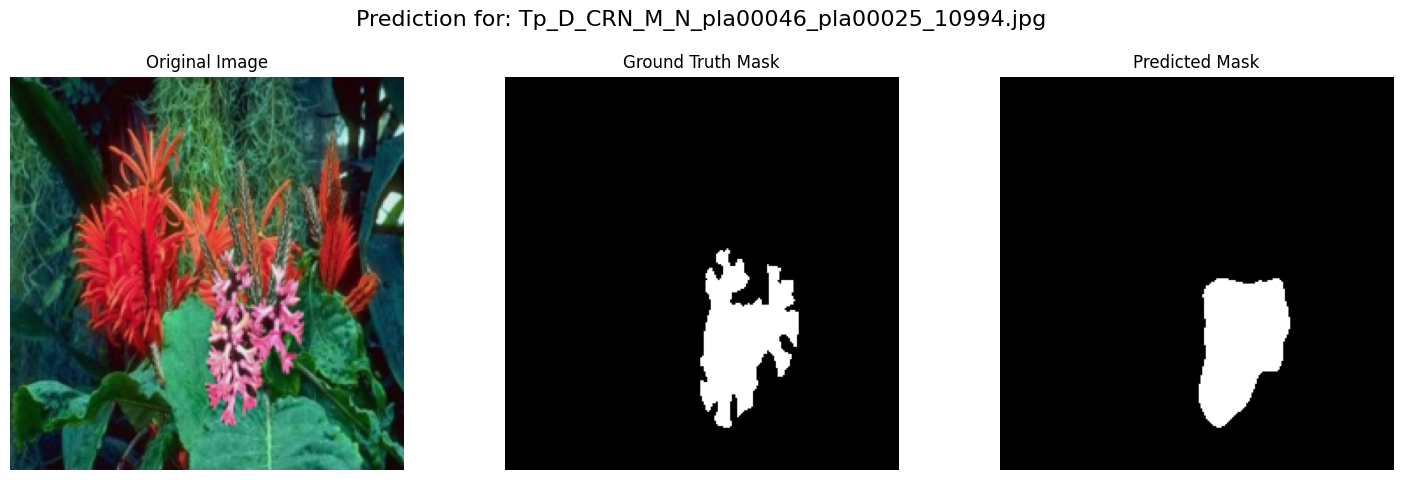


Visualizing sample index 2003: Tp_S_NRN_S_O_cha10187_cha10187_12308.jpg


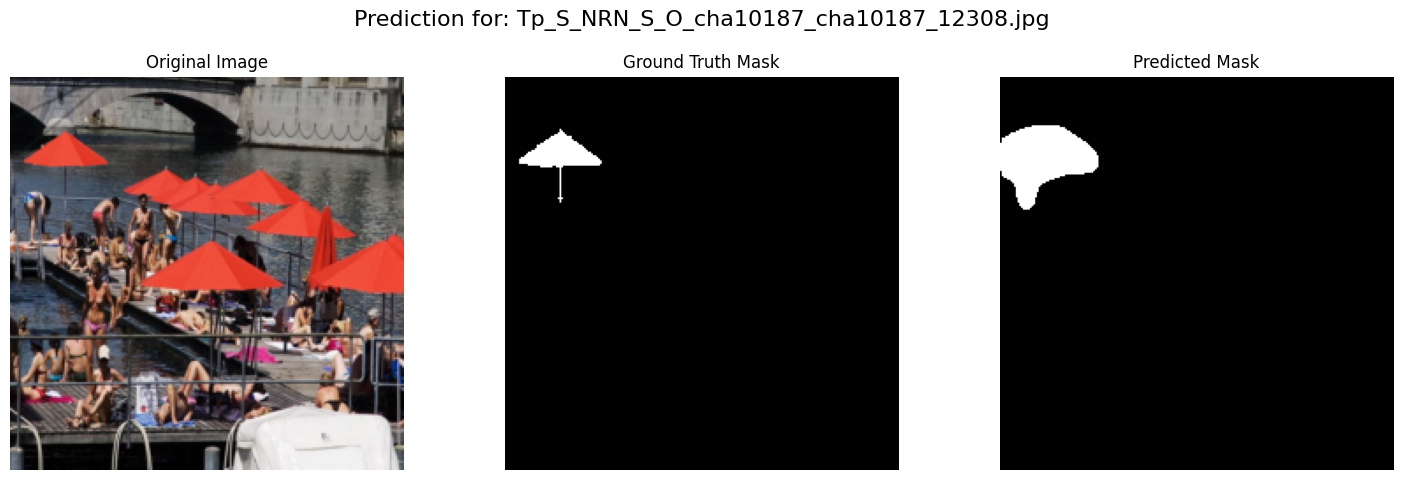


Visualization complete.


In [11]:
# --- Select images to visualize ---
# You can pick specific indices from your val_dataset_raw.data_pairs
# Or manually specify paths for your 5 custom images.

# Example: Picking a few indices from your validation dataset
# It's good to pick diverse examples if you know their indices
indices_to_visualize = [
    0,   # First image in the dataset
    100, # A mid-way image
    len(val_dataset_raw) - 1 # Last image in the dataset
]

# If you have specific complex forgeries you want to show, get their paths manually:
# custom_image_paths = [
#     ("/content/drive/MyDrive/TransCMFD dataset/CASIA2/Tp/example_complex_1.jpg",
#      "/content/drive/MyDrive/TransCMFD dataset/CASIA2/CASIA 2 Groundtruth/example_complex_1_gt.png"),
#     # Add more (image_path, mask_path) tuples
# ]

print("\n--- Visualizing Predictions ---")

# Visualize from the automatically loaded validation dataset
for idx in indices_to_visualize:
    if idx < len(val_dataset_raw.data_pairs):
        image_path, mask_path = val_dataset_raw.data_pairs[idx]
        print(f"\nVisualizing sample index {idx}: {os.path.basename(image_path)}")
        visualize_single_prediction(model, image_path, mask_path, device, MODEL_INPUT_TRANSFORM, DISPLAY_IMAGE_TRANSFORM)
    else:
        print(f"Index {idx} is out of bounds for the dataset.")

# If you create manual images, uncomment and use this:
# print("\n--- Visualizing Custom/Manual Forgeries ---")
# for img_path, mask_path in custom_image_paths:
#     print(f"\nVisualizing custom image: {os.path.basename(img_path)}")
#     visualize_single_prediction(model, img_path, mask_path, device, MODEL_INPUT_TRANSFORM, DISPLAY_IMAGE_TRANSFORM)

print("\nVisualization complete.")